In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import sys

script_path = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(script_path))

# Lion

In [3]:
import torch
import numpy as np

In [4]:
print('GPU: ',torch.cuda.is_available())
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU:  True


In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
data_path = os.path.join(script_path,'data','demo','lion.png')
save_path = os.path.join(script_path,'out','Real-world')

RGB


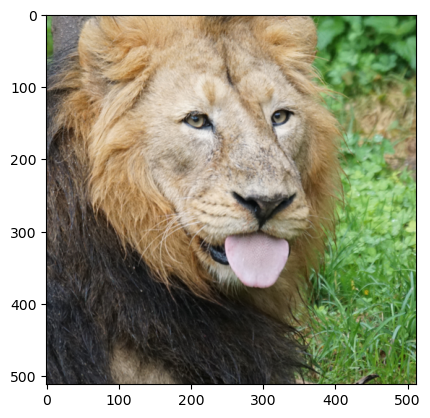

In [7]:
from PIL import Image
img = Image.open(data_path)
print(img.mode)
plt.imshow(img)

### scale lion

RGB


/tmp/ipykernel_140504/2239330588.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((min_side,min_side), Image.ANTIALIAS)  # resizes image in-place


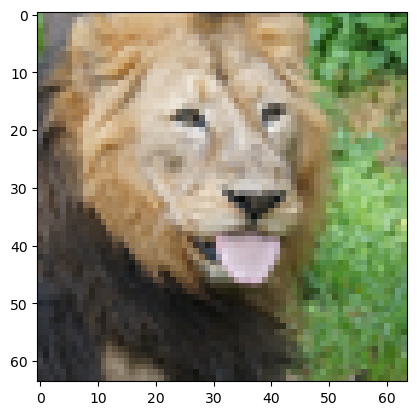

In [8]:
min_side = 64

from PIL import Image
img = Image.open(data_path)
img.thumbnail((min_side,min_side), Image.ANTIALIAS)  # resizes image in-place
print(img.mode)
plt.imshow(img)

#### RGB split

In [9]:
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.ToTensor()])

lion = transform(img)
print(torch.min(lion), torch.max(lion))

tensor(0.0275) tensor(0.9412)


In [10]:
def RGB_split(img):
    r, g, b = img.unbind(0)
    C, H, W = img.shape
    
    R_img = torch.zeros([H, W, C])
    R_img[:,:,0] = r
    G_img = torch.zeros([H, W, C])
    G_img[:,:,1] = g
    B_img = torch.zeros([H, W, C])
    B_img[:,:,2] = b
    
    return R_img, G_img, B_img

In [11]:
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.ToTensor()])

lion = transform(img)
print(torch.min(lion), torch.max(lion))

tensor(0.0275) tensor(0.9412)


In [12]:
C, H, W = lion.shape
R_lion, G_lion, B_lion = RGB_split(lion)

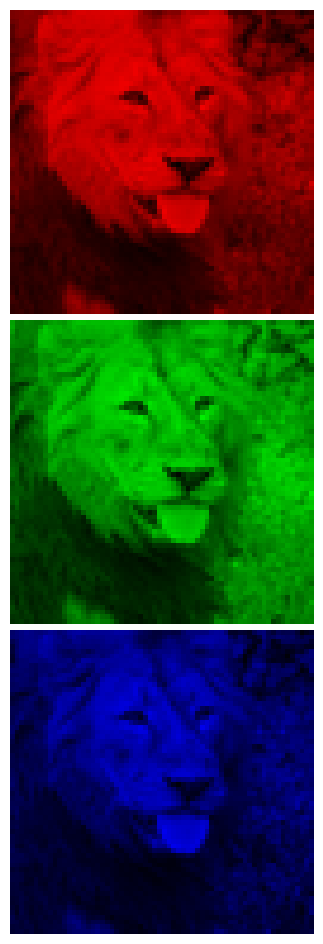

In [13]:
fig = plt.figure(figsize=(4,12))

ax = fig.add_subplot(3, 1, 1)
ax.imshow(R_lion)
ax.set_axis_off()
#plt.title('Red Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(3, 1, 2)
ax.imshow(G_lion)
ax.set_axis_off()
#plt.title('Green Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(3, 1, 3)
ax.imshow(B_lion)
ax.set_axis_off()
#plt.title('Blue Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

fig.subplots_adjust(hspace=0.02)
plt.show()

#fig.savefig(save_path+'/Lenna RGB.pdf'.format(1,2),bbox_inches='tight')
#fig.savefig(save_path+'/Lenna RGB.jpg'.format(1,2),bbox_inches='tight')

### Generate initial lion

In [ ]:
import time
eta = 0.01  # Learning rate.
num_iterations = 20000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

In [15]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)


ini_lion = torch.rand(lion.shape)

In [16]:
print(torch.min(ini_lion), torch.max(ini_lion))

tensor(5.3048e-05) tensor(1.0000)


In [17]:
R_lion, G_lion, B_lion = RGB_split(ini_lion)

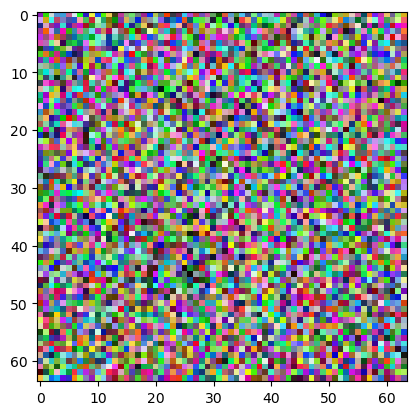

In [18]:
plt_ini_lion = torch.zeros([H, W, C])
plt_ini_lion[:,:,0], plt_ini_lion[:,:,1], plt_ini_lion[:,:,2] = R_lion[:,:,0], G_lion[:,:,1], B_lion[:,:,2]
plt.imshow(plt_ini_lion)
ax.set_axis_off()

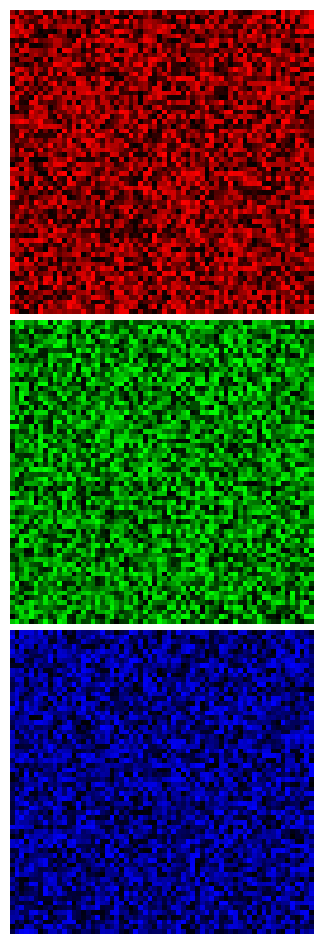

In [19]:
fig = plt.figure(figsize=(4,12))

ax = fig.add_subplot(3, 1, 1)
ax.imshow(R_lion)
ax.set_axis_off()
#plt.title('Red Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(3, 1, 2)
ax.imshow(G_lion)
ax.set_axis_off()
#plt.title('Green Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

ax = fig.add_subplot(3, 1, 3)
ax.imshow(B_lion)
ax.set_axis_off()
#plt.title('Blue Channel',y=0.95, c='w', loc='center',horizontalalignment='center', verticalalignment='top')

fig.subplots_adjust(hspace=0.02)
plt.show()

#fig.savefig(save_path+'/Lenna RGB.pdf'.format(1,2),bbox_inches='tight')
#fig.savefig(save_path+'/Lenna RGB.jpg'.format(1,2),bbox_inches='tight')

## Single

For loop over channel  
and loss is computed based on the 3 channel one

In [20]:
import time
eta = 0.01  # Learning rate.
num_iterations = 70000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

In [21]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

In [22]:
def greedy_1(y_t, y_s):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    
    return ind

In [23]:
def gradient(x, f_x, y, x_list, K): #add a argument "type" for specified loss
    '''
    input x is for mapping to get f_x so redesign this function and only leave y,f_x as input
    
    obj: 
    input y: [label1]
    input f_x: [x1]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    output gradient: [x1,x2,x3] long as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    #square_loss
    '''
    actually just one example so unsqueeze is trival
    '''
    gradient = -2*(y-f_x)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    actually just one example so unsqueeze is trival
    '''
    gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

### Training

In [ ]:
#clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = ini_lion.flatten(start_dim=1).cuda()
f_t.append(y_0.cpu())
y_star = lion.flatten(start_dim=1).cuda()
loss_0 = torch.norm(y_0-y_star)/(C*H*W)
loss_t.append(loss_0.item())
tm_t.append(0)

step = 0.05*num_iterations
for channel in range(C):
    iter_count = 0
    while iter_count < num_iterations:
        '''
        if np.remainder(iter_count, step) == 0:
            sel_idx = greedy_B(f_t[-1], y_star, 1)

        for random selection, generate sel_idx by random, random seed can be set as iter_count
        '''

        sel_idx = greedy_1(f_t[-1][channel].cuda(), y_star[channel])#, pool=True, plScale= 0.8
        '''
        np.random.seed(iter_count)
        sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
        '''

        '''
        example: [[x1,x2],[x1,x2]] int pixel point
        '''

        example = pixels[sel_idx]#torch.tensor([14,14])
        
        '''
        intorduce replacement
        '''
        label = y_star[channel][sel_idx] #f_star(example,channel)
        f_x = f_t[-1][channel][sel_idx]

        '''
        Need to clone otherwise previsous data will be changed as well
        '''
        temp = f_t[-1].detach().clone()
        temp[channel] = f_t[-1][channel].cuda() -eta*gradient(example, f_x.cuda(), label, pixels, rbf_kernel)
        
        f_t.append(temp.cpu())
        
        l_t = torch.norm(f_t[-1].cuda()-y_star)/(C*H*W)
        loss_t.append(l_t.item()) #norm over the cube
        tm_t.append(time.time() - training_start_time)
        iter_count += 1
        print('Channel: ',channel+1,' ',iter_count,'-th loss: ',loss_t[-1])
        print('Training finished, took {:.2f}s'.format(tm_t[-1]))

Store necessary f_t

In [25]:
a_f_t = []

ilist = [0, 10000, 20000, 30000, 50000, 69999]

for channel in range(C):
    ite_list = np.array(ilist)+channel*num_iterations
    ite_list = list(ite_list)
    for i in ite_list:
        a_f_t.append(f_t[i])

In [26]:
torch.save([a_f_t, loss_t, tm_t],save_path+'/Single_random_ini.pt')

Load data

In [24]:
a_f_t, loss_t, tm_t = torch.load(save_path+'/Single_random_ini.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

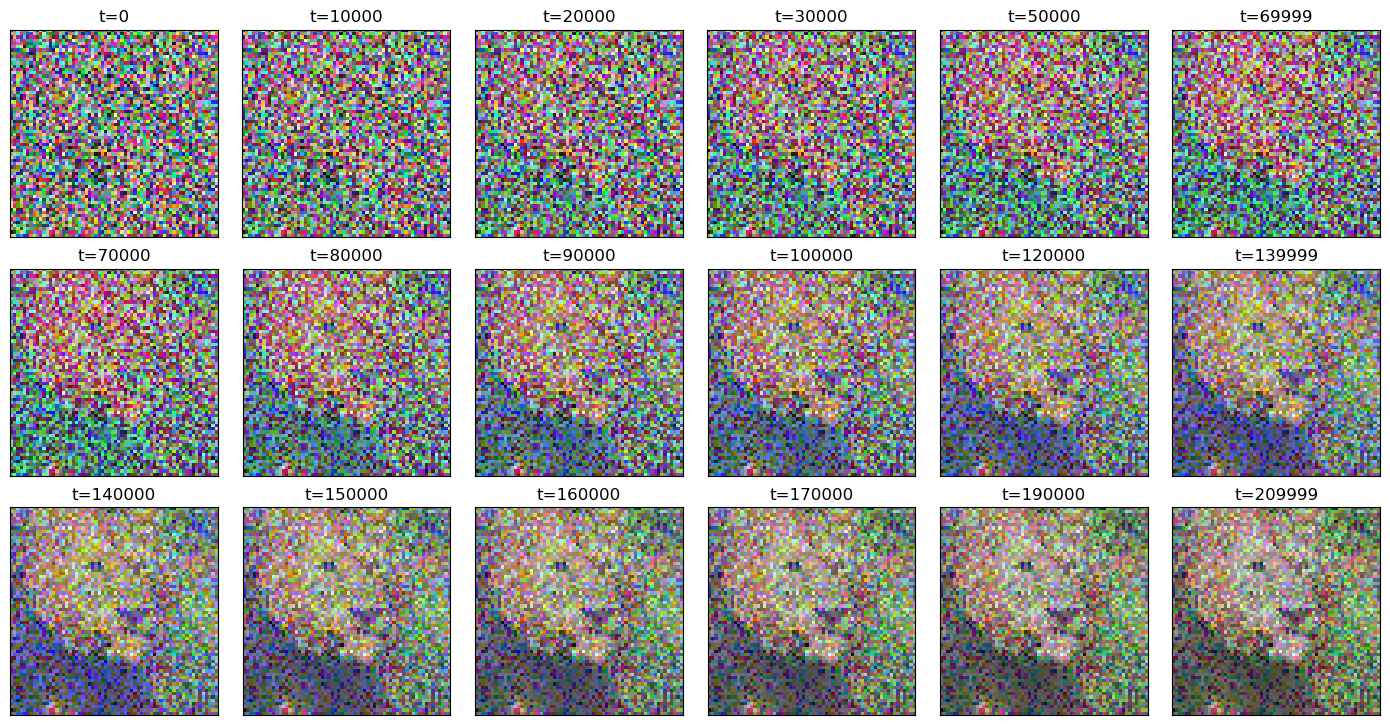

In [25]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = C+1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = -.7, hspace = .15)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,12))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ilist = [0, 10000, 20000, 30000, 50000, 69999] #[0,50,150,250,350, 550]


for channel in range(C):
    ite_list = np.array(ilist)+channel*num_iterations
    ite_list = list(ite_list)
    for i in ite_list:
        j = ite_list.index(i)
        mi = j + channel*6 #omit otherwise
        
        #Z = f_t[i].reshape(C, min_side,min_side) # alternative
        Z = a_f_t[mi].reshape(C, min_side,min_side)
        
        

        r_Z, g_Z, b_Z = Z.unbind(0)

        Z = torch.zeros([H, W, C])
        Z[:,:,0], Z[:,:,1], Z[:,:,2] = r_Z, g_Z, b_Z

        # Plot the surface.
        ax = fig.add_subplot(grid[channel,j])

        #surf = ax.contourf(X, -Y, Z, norm = norm, antialiased=False)

        ax.imshow(Z,norm = norm)
        
        # Customize the z axis.
        #ax.set_zlim(-1.01, 1.01)
        #ax.zaxis.set_major_locator(LinearLocator(10))
        # A StrMethodFormatter is used automatically
        #ax.zaxis.set_major_formatter('{x:.02f}')
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_zticks([])
        # Add a color bar which maps values to colors.

        #ax.view_init(90,0)

        plt.title('t={}'.format(i))
    #fig.colorbar(surf, shrink=0.22, aspect=5)

plt.show()
fig.savefig(save_path+'/Single_random_ini.pdf'.format(1,2),bbox_inches='tight')

show less

In [26]:
less_a_f_t = []
for i in [0,1,4,9,13,17]:
    less_a_f_t.append(a_f_t[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


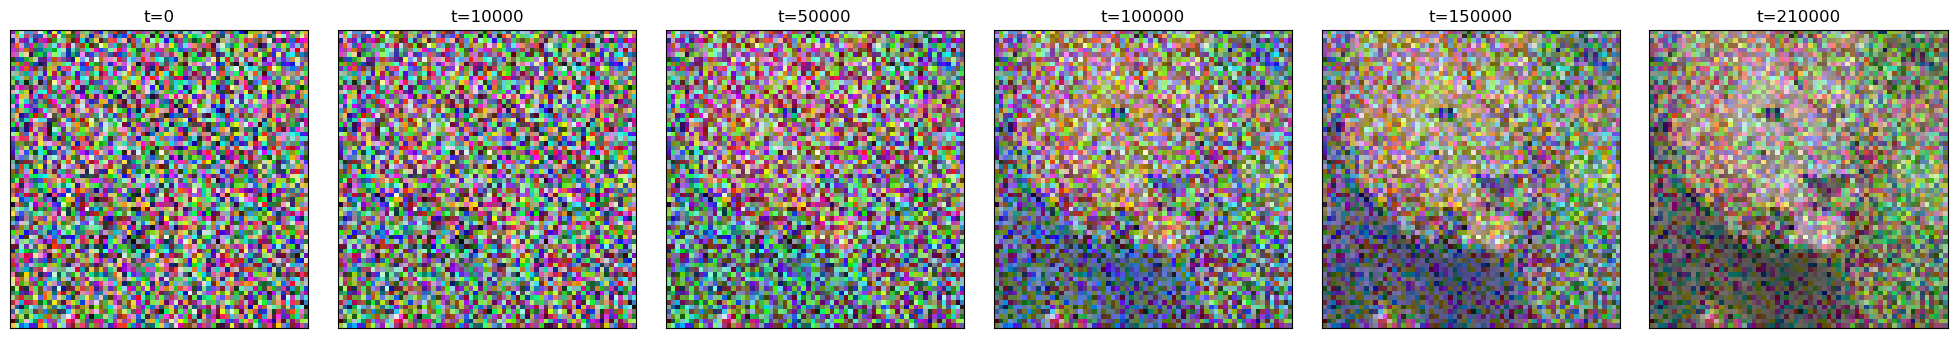

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = 1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = .1, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,4))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 10000, 50000, 100000, 150000, 210000] #[0, 5000, 10000, 50000, 100000, 150000]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise

    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = less_a_f_t[mi].reshape(C, min_side,min_side)

    r_Z, g_Z, b_Z = RGB_split(Z)

    im_Z = torch.zeros([H, W, C])
    im_Z[:,:,0], im_Z[:,:,1], im_Z[:,:,2] = r_Z[:,:,0], g_Z[:,:,1], b_Z[:,:,2]
    ax = fig.add_subplot(grid[0,j])
    ax.imshow(im_Z,norm = norm)
    plt.title('t={}'.format(i))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Single_random_ini_less.pdf'.format(1,2),bbox_inches='tight')

In [31]:
from ignite.metrics import PSNR
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')
for i in less_a_f_t:
    state = default_evaluator.run([[i.reshape(C, min_side,min_side), lion]])
    print(state.metrics['psnr'])

8.726948902498838
9.156011321110867
10.23325898591578
11.663240483632928
12.986675354866248
14.486816626962948


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


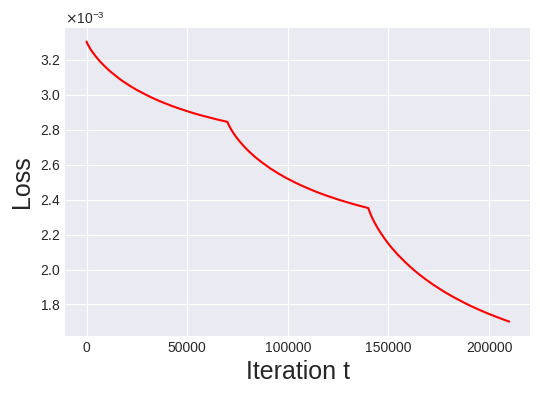

In [32]:
#from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')   #grey background, white line style

sf = plt.figure(figsize=(6,4))
plt.plot(loss_t,color='red',linestyle='-')

plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.ticklabel_format(style='sci', scilimits=(-3,-2), axis='y',useMathText=True)
plt.legend()
plt.xlabel('Iteration t', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## Vanilla

In [28]:
import time
eta = 0.01  # Learning rate.
num_iterations = 210000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

In [29]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

In [31]:
def greedy_1(y_t, y_s):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    
    return ind

In [32]:
def gradient(x, f_x, y, x_list, K): #add a argument "type" for specified loss
    '''
    input x is for mapping to get f_x so redesign this function and only leave y,f_x as input
    
    obj: 
    input y: [label1]
    input f_x: [x1]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    output gradient: [x1,x2,x3] long as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    #square_loss
    '''
    actually just one example so unsqueeze is trival
    '''
    gradient = -2*(y-f_x)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    actually just one example so unsqueeze is trival
    '''
    '''
    Do not mean!!!!
    '''
    #gradient = torch.mean(gradient,axis=0)
    #print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

### Training

In [ ]:
#clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = ini_lion.flatten(start_dim=1).cuda()
f_t.append(y_0.cpu())
y_star = lion.flatten(start_dim=1).cuda()
loss_0 = torch.norm(y_0-y_star)/(C*H*W)
loss_t.append(loss_0.item())
tm_t.append(0)

iter_count = 0

step = 0.05*num_iterations
while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)

    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    sel_idx = greedy_1(f_t[-1].cuda(), y_star)#, pool=True, plScale= 0.8
    #print(sel_idx)
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''

    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    
    '''
    pixels is a one dimensional tensor and universal so we can just index like this
    '''
    example = pixels[sel_idx] 
    
    '''
    intorduce replacement
    '''
    
    label = torch.vstack([y_star[0,sel_idx[0]],y_star[1,sel_idx[1]],y_star[2,sel_idx[2]]])
    
    f_x = torch.vstack([f_t[-1][0,sel_idx[0]],f_t[-1][1,sel_idx[1]],f_t[-1][2,sel_idx[2]]])
    
    '''
    pixels are universal
    '''
    f_tt = f_t[-1].cuda() -eta*gradient(example, f_x.cuda(), label, pixels, rbf_kernel)
    f_t.append(f_tt.cpu())
    
    l_t = torch.norm(f_t[-1].cuda()-y_star)/(C*H*W)
    loss_t.append(l_t.item()) #norm over the cube
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

Store necessary f_t

In [39]:
a_f_t = []

ite_list =  [0, 10000, 50000, 100000, 150000, 210000]

for i in ite_list:
    a_f_t.append(f_t[i])

In [40]:
torch.save([a_f_t, loss_t, tm_t],save_path+'/Vanilla_random_ini.pt')

Load data

In [33]:
a_f_t, loss_t, tm_t = torch.load(save_path+'/Vanilla_random_ini.pt')

In [34]:
def RGB_split(img):
    r, g, b = img.unbind(0)
    C, H, W = img.shape
    
    R_img = torch.zeros([H, W, C])
    R_img[:,:,0] = r
    G_img = torch.zeros([H, W, C])
    G_img[:,:,1] = g
    B_img = torch.zeros([H, W, C])
    B_img[:,:,2] = b
    
    return R_img, G_img, B_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

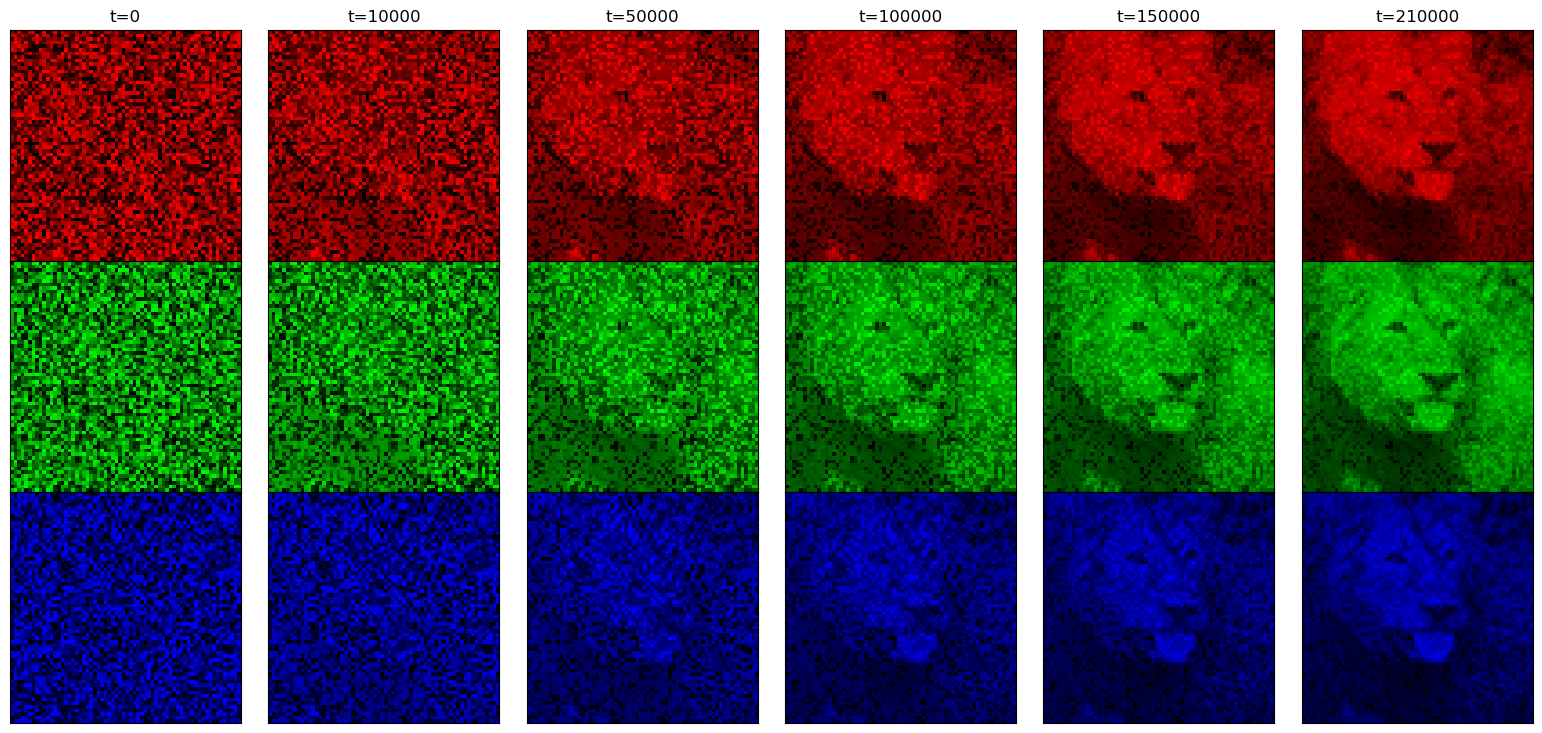

In [35]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = C+1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = -.6, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,12))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 10000, 50000, 100000, 150000, 210000] #[0,50,150,250,350, 550]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = a_f_t[mi].reshape(C, min_side,min_side)
    
    r_Z, g_Z, b_Z = RGB_split(Z)
    
    cmb_Z = [r_Z, g_Z, b_Z]
    
    for prl in range(C):
        ax = fig.add_subplot(grid[prl,j])
        ax.imshow(cmb_Z[prl],norm = norm)
        if prl == 0:
            plt.title('t={}'.format(i))
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Vanilla RGB_random_ini.pdf'.format(1,2),bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


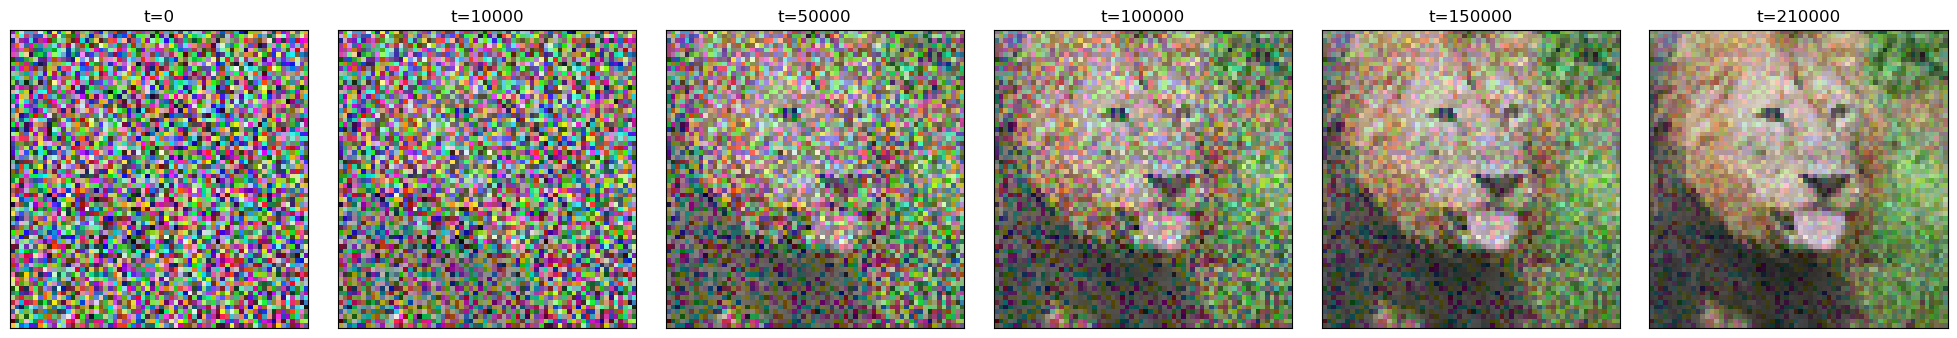

In [36]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = 1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = .1, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,4))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 10000, 50000, 100000, 150000, 210000] #[0, 5000, 10000, 50000, 100000, 150000]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = a_f_t[mi].reshape(C, min_side,min_side)
    
    r_Z, g_Z, b_Z = RGB_split(Z)
    
    im_Z = torch.zeros([H, W, C])
    im_Z[:,:,0], im_Z[:,:,1], im_Z[:,:,2] = r_Z[:,:,0], g_Z[:,:,1], b_Z[:,:,2]
    ax = fig.add_subplot(grid[0,j])
    ax.imshow(im_Z,norm = norm)
    plt.title('t={}'.format(i))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Vanilla_random_ini.pdf'.format(1,2),bbox_inches='tight')

In [45]:
from ignite.metrics import PSNR
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')
for i in a_f_t:
    state = default_evaluator.run([[i.reshape(C, min_side,min_side), lion]])
    print(state.metrics['psnr'])

8.726948902498838
10.009885464544594
13.194867150812483
16.265263252546344
18.978997757878513
21.99518267081682


## Communicated

In [37]:
import time
eta = 0.01  # Learning rate.
num_iterations = 210000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, H, 1)
x2 = torch.arange(0, W, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

### each iteration

Train Advanced matrix A

In [38]:
y_0 = ini_lion.flatten(start_dim=1).cuda()
y_star = lion.flatten(start_dim=1).cuda()
f_0_T = y_0.T
f_s_T = y_star.T

In [39]:
class AdvancedM(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AdvancedM, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        torch.nn.init.eye_(self.linear.weight)

    def forward(self, x):
        nor = self.linear.weight.sum(dim=1)
        outputs = self.linear(x)/nor
        return outputs

In [40]:
def A_t(f_t, f_star, N=5000, epsi=0.0001, eta = 0.0001):
    '''
    f_t_T_unnor = f_t.T
    f_s_T_unnor = f_star.T
    
    f_t_T = torch.nn.functional.normalize(f_t_T_unnor,p=2.0, dim=1)
    f_s_T = torch.nn.functional.normalize(f_s_T_unnor,p=2.0, dim=1)
    '''
    
    f_t_T = f_t.T
    f_s_T = f_star.T
    
    MatrixA = AdvancedM(len(f_t), len(f_star)).cuda()
    optimizer = torch.optim.SGD(MatrixA.parameters(), lr=eta)
    
    loss_t = []

    loss_t.append(torch.norm(MatrixA(f_t_T)-f_s_T))

    iter_count = 0
    while iter_count < N and loss_t[-1] > epsi:
        iter_count += 1
        
        roll = MatrixA

        loss = torch.norm(MatrixA(f_t_T)-f_s_T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if torch.norm(MatrixA(f_t_T)-f_s_T).item() > loss_t[-1]:
            MatrixA = roll #rolling
            break    
        
        loss_t.append(loss.item())
        #print(iter_count,'-th test loss:', loss_t[-1])
        
    A = MatrixA.state_dict()['linear.weight']
    A = A/(A.sum(dim=1))[:, None]
    print('A norm for each is:', A.norm(dim=1))

    return MatrixA, A


In [ ]:
#clear_print
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []

y_0 = ini_lion.flatten(start_dim=1).cuda()
f_t.append(y_0.cpu())

y_star = lion.flatten(start_dim=1).cuda()
loss_0 = torch.norm(y_0-y_star)/(C*H*W)
loss_t.append(loss_0.item())
tm_t.append(0)

iter_count = 0

step = 0.05*num_iterations
while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)

    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''

    '''
    Advanced, commnication
    '''
    if iter_count<100:
        MatrixA_t, A = A_t(f_t[-1].cuda(), y_star)
        A_f_t=MatrixA_t(f_t[-1].T.cuda()).detach().T.cpu()
    else:
        A_f_t = f_t[-1]

    sel_idx = greedy_1(A_f_t.cuda(), y_star)#, pool=True, plScale= 0.8
    print(A)
    #print(sel_idx)
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''

    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''

    '''
    pixels is a one dimensional tensor and universal so we can just index like this
    '''
    example = pixels[sel_idx]

    '''
    intorduce replacement
    '''

    label = torch.vstack([y_star[0,sel_idx[0]],y_star[1,sel_idx[1]],y_star[2,sel_idx[2]]])
    
    f_x = torch.vstack([A_f_t[0,sel_idx[0]],A_f_t[1,sel_idx[1]],A_f_t[2,sel_idx[2]]])
    

    '''
    pixels are universal
    '''
    f_tt = A_f_t.cuda() -eta*gradient(example, f_x.cuda(), label, pixels, rbf_kernel)
    f_t.append(f_tt.cpu())

    l_t = torch.norm(f_t[-1].cuda()-y_star)/(C*H*W)
    loss_t.append(l_t.item()) #norm over the cube
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

In [51]:
a_f_t = []

ite_list =  [0, 10000, 50000, 100000, 150000, 210000]

for i in ite_list:
    a_f_t.append(f_t[i])

In [52]:
torch.save([a_f_t, loss_t, tm_t],save_path+'/Advanced_each_ite_random_ini.pt')

Load data

In [41]:
a_f_t, loss_t, tm_t = torch.load(save_path+'/Advanced_each_ite_random_ini.pt')

In [42]:
def RGB_split(img):
    r, g, b = img.unbind(0)
    C, H, W = img.shape
    
    R_img = torch.zeros([H, W, C])
    R_img[:,:,0] = r
    G_img = torch.zeros([H, W, C])
    G_img[:,:,1] = g
    B_img = torch.zeros([H, W, C])
    B_img[:,:,2] = b
    
    return R_img, G_img, B_img

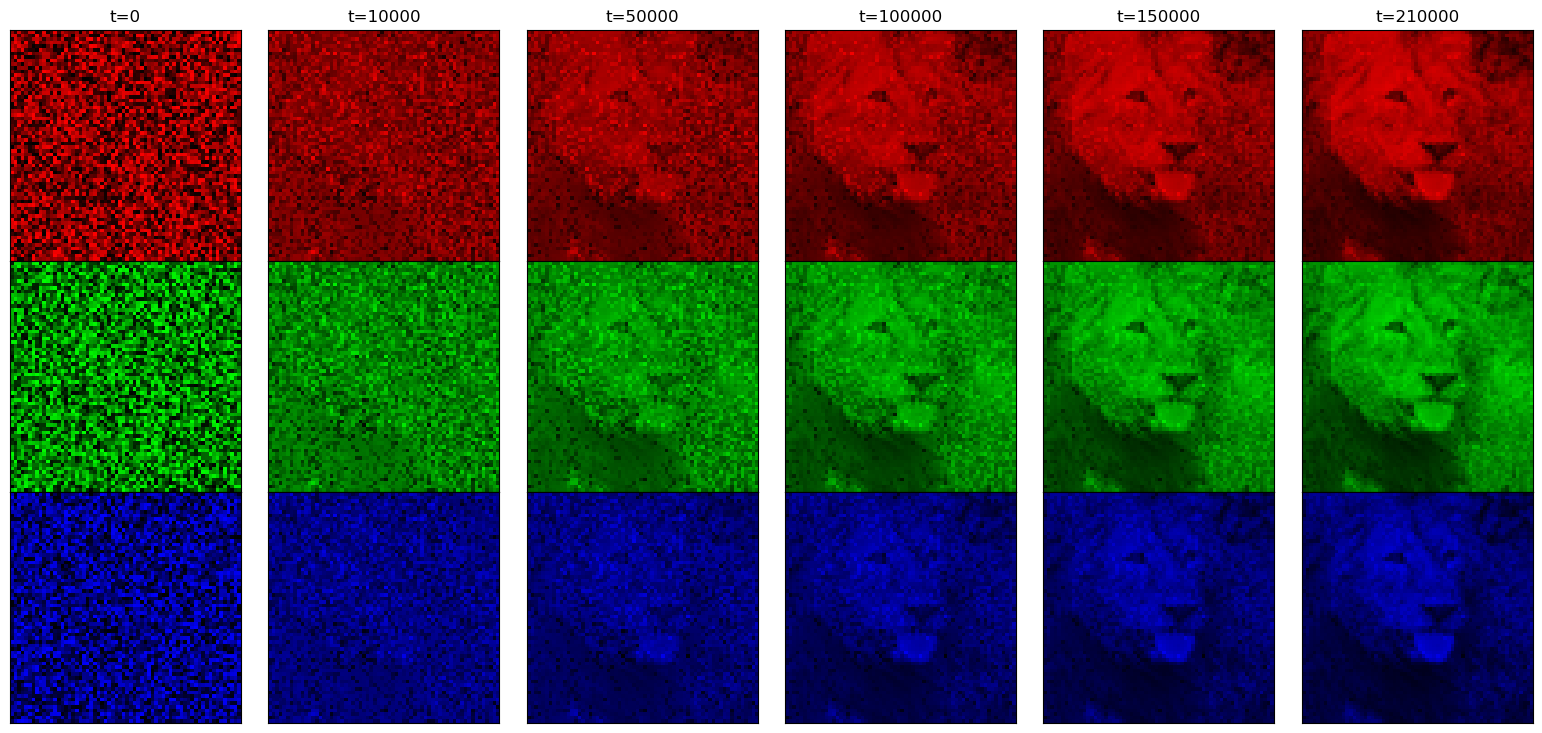

In [43]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = C+1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = -.6, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,12))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 10000, 50000, 100000, 150000, 210000]   #ite_list =  [0, 2000, 10000, 20000, 50000, 90000] #[0,50,150,250,350, 550]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = a_f_t[mi].reshape(C, min_side,min_side)
    
    r_Z, g_Z, b_Z = RGB_split(Z)
    
    cmb_Z = [r_Z, g_Z, b_Z]
    
    for prl in range(C):
        ax = fig.add_subplot(grid[prl,j])
        ax.imshow(cmb_Z[prl],norm = norm)
        if prl == 0:
            plt.title('t={}'.format(i))
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Advanced RGB_each_ite_random_ini.pdf'.format(1,2),bbox_inches='tight')

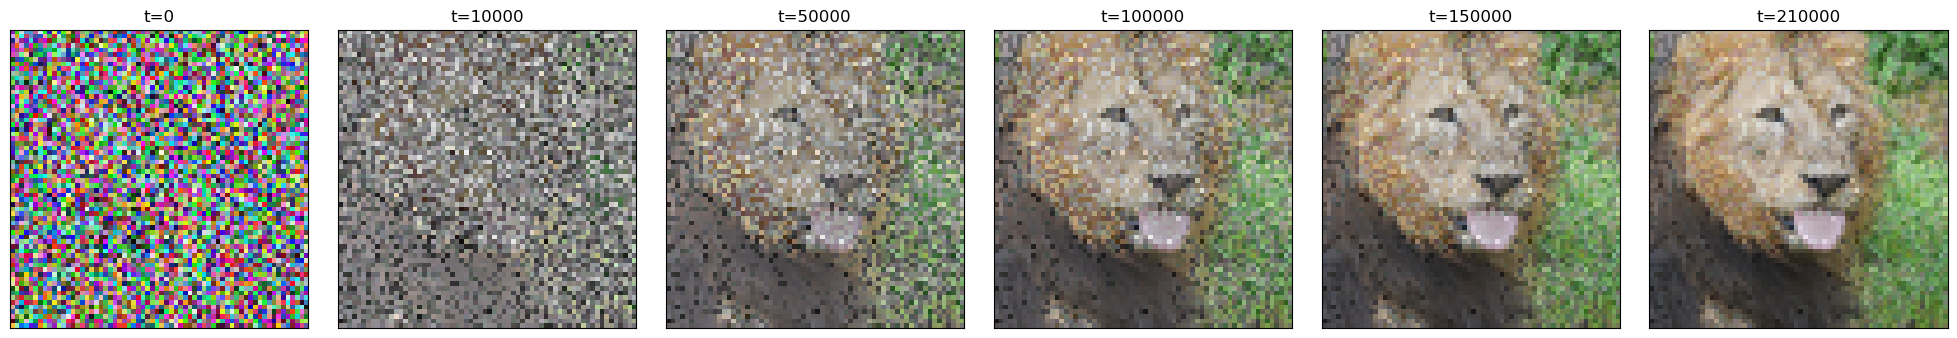

In [44]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

rows = 1
columns = 6

grid = plt.GridSpec(rows, columns, wspace = .1, hspace = 0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(25,4))

X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
X, Y = np.meshgrid(X, Y)

ite_list =  [0, 10000, 50000, 100000, 150000, 210000] #[0,50,150,250,350, 550]


for i in ite_list:
    j = ite_list.index(i)
    mi = j #omit otherwise
    
    #Z = f_t[i].reshape(C, min_side,min_side) # alternative
    Z = a_f_t[mi].reshape(C, min_side,min_side)
    
    r_Z, g_Z, b_Z = RGB_split(Z)
    
    im_Z = torch.zeros([H, W, C])
    im_Z[:,:,0], im_Z[:,:,1], im_Z[:,:,2] = r_Z[:,:,0], g_Z[:,:,1], b_Z[:,:,2]
    ax = fig.add_subplot(grid[0,j])
    ax.imshow(im_Z,norm = norm)
    plt.title('t={}'.format(i))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
fig.savefig(save_path+'/Advanced_each_ite_random_ini.pdf'.format(1,2),bbox_inches='tight')

In [57]:
from ignite.metrics import PSNR
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')
for i in a_f_t:
    state = default_evaluator.run([[i.reshape(C, min_side,min_side), lion]])
    print(state.metrics['psnr'])

8.726948902498838
12.384768057996851
15.615124850352364
18.735017682972867
21.49937696286125
24.58394822297261


### Converge performance

Can introduce PFT for comparison

In [45]:
_, Singleloss_t, _ = torch.load(save_path+'/Single_random_ini.pt')
_, Advancedloss_t, _ = torch.load(save_path+'/Advanced_each_ite_random_ini.pt')
_, Vanillaloss_t, _ = torch.load(save_path+'/Vanilla_random_ini.pt')

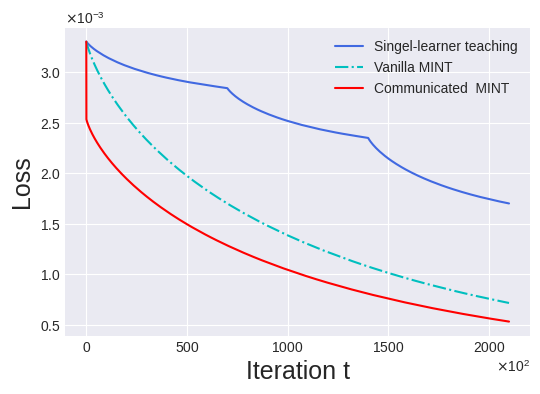

In [46]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')   #grey background, white line style

sf = plt.figure(figsize=(6,4))
ax = sf.add_subplot()
plt.plot(Singleloss_t,color='royalblue',label='Singel-learner teaching')
plt.plot(Vanillaloss_t,color='c',linestyle='-.',label='Vanilla MINT')
plt.plot(Advancedloss_t,color='red',label='Communicated  MINT')

plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.ticklabel_format(style='sci', scilimits=(-3,-2), axis='y',useMathText=True)
plt.ticklabel_format(style='sci', scilimits=(2,2), axis='x',useMathText=True)
plt.legend()
#plt.xlim(-0.5,600)
plt.xlabel('Iteration t', fontsize=18)
plt.ylabel('Loss', fontsize=18)

'''#-----------------zoom
xlim_1, xlim_2 = 0, 20
ax_zoom = sf.add_axes([0.2, 0.15, 0.1, 0.4], facecolor='white')
plt.plot(np.arange(xlim_1, xlim_2,1),Singleloss_t[xlim_1:xlim_2],color='royalblue')
plt.plot(np.arange(xlim_1, xlim_2,1),Vanillaloss_t[xlim_1:xlim_2],color='c',linestyle='-.')
plt.plot(np.arange(xlim_1, xlim_2,1),Advancedloss_t[xlim_1:xlim_2],color='red')

mark_inset(ax, ax_zoom, loc1=4, loc2=2, fc="none", ec="0.5")'''

plt.ticklabel_format(style='sci', scilimits=(-5,-6), axis='y',useMathText=True)


plt.show()
sf.savefig(save_path+'/Loss_random_ini.pdf',bbox_inches='tight')